In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score
from config import ExperimentConfig
from experiments.experiment import Experiment
#from config.common_path import get_ba
%matplotlib inline


/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
run_id = 8
ROOT_PATH = "/Users/sunilkumar/concept_learning/image_classification/"
config1 = ExperimentConfig(ROOT_PATH, 4, 10, [64, 128, 32])
config2 = ExperimentConfig(ROOT_PATH, 4, 5, [64, 128, 32])
exp_config = config1
N_3 = exp_config.num_units[exp_config.num_decoder_layer - 2]
N_2 = exp_config.num_units[exp_config.num_decoder_layer - 3]
Z_DIM = exp_config.Z_DIM
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
SPLIT_NAME = exp_config.split_name
exp_config.create_directories(run_id)
DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS = exp_config.DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS
# filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, "train")
# mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)

In [3]:
def get_base_path(root_path, z_dim, n_3, n_2, version = ""):
    return os.path.join(root_path, "Exp_{:02d}_{:03}_{:03d}_{}/".format(z_dim, n_3, n_2, version))


In [4]:
MODEL_NAME ="VAE"

annotator = "SUNIL"
num_files = 2
NUMBER_OF_ROWS = 16
NUM_DIGITS_PER_ROW = 4
MAX_BACKUPS = 10
ANNOTATED_CSV = "annotation.csv"
last_epoch = 20
eval_interval = 300

num_images = 2
num_rows_per_image = 16
num_digits_per_row = 4



In [5]:
def read_label(label_file):
    labels = {}
    for file_number in range(num_files):
        label_df = pd.read_csv(label_file.format(file_number))
        #label_df = pd.read_csv(label_file)
        labels[file_number] = label_df["label"].values
    return labels

def get_label_reconstructed(_df):
    labels =  np.ones(num_rows_per_image * num_digits_per_row) * -2
    _df = _df.fillna("xxxx")
    for row in _df.iterrows():
        text_ = [-1] * num_digits_per_row

        row_text_ = row[1]["text"]
        if isinstance(row_text_,float):
            row_text_ = str(row_text_)
        row_text_ = row_text_.strip()
        if len(row_text_) != 0:
            if len(row_text_) < 4:
                for i in range(4-len(row_text_)):
                    text_[i] = 0
            offset = 4 - len(row_text_)
            for i,c in enumerate(row_text_):
                if c.isdigit():
                    text_[i+offset] = int(c)
                elif c == 'x':
                    text_[i+offset] = -1
                else:
                    raise Exception("Invalid character in annotated data - ",row[1]["num_rows_annotated"])

        for i in range(num_digits_per_row)  :
            offset = (row[1]["num_rows_annotated"] - 1) * num_digits_per_row
            labels[i + offset] = text_[i]

    return labels


In [6]:
def compute_accruacy(df,step,epoch,num_images):
    df1 = df[(df["epoch"] == epoch) & (df["step"] == step)]
    labels_batch = []
    reconstructed_batch = []
    for image_no in range(num_images):
        _df = df1[df1["_idx"] == image_no]
        if _df.shape[0] > 0 :
            try:
                reconstructed = get_label_reconstructed(_df[["num_rows_annotated", "text"]])
            except Exception as e:
                print("Invalid character in annotation,epoch {:01d} , step {:01d}".format(epoch,step))
                print(str(e))
                continue
                #exit()
            _reconstructed_indices = reconstructed != -2
            reconstructed_batch.extend(reconstructed[_reconstructed_indices])
            labels_batch.extend(labels[image_no][_reconstructed_indices])
    accuracy = accuracy_score(labels_batch,reconstructed_batch)
    return accuracy


In [7]:
def get_annotations(annotated_path):
    df = None
    for annotation_file in os.listdir(annotated_path):
        if annotation_file.rsplit(".",1)[1] == "csv":
            annotation_csv = os.path.join(ANNOTATED_PATH, annotation_file)
            _df = pd.read_csv(annotation_csv)
            if df is None:
                df = _df
            else:
                df = pd.concat([df,_df])

    unique = df.groupby(["epoch","step"]).size().reset_index().rename(columns={0:'count'})
    return df,unique


Invalid character in annotation,epoch 28 , step 2
('Invalid character in annotated data - ', 2)
/Users/sunilkumar/concept_learning/image_classification/combined_analysis/accuracy.png


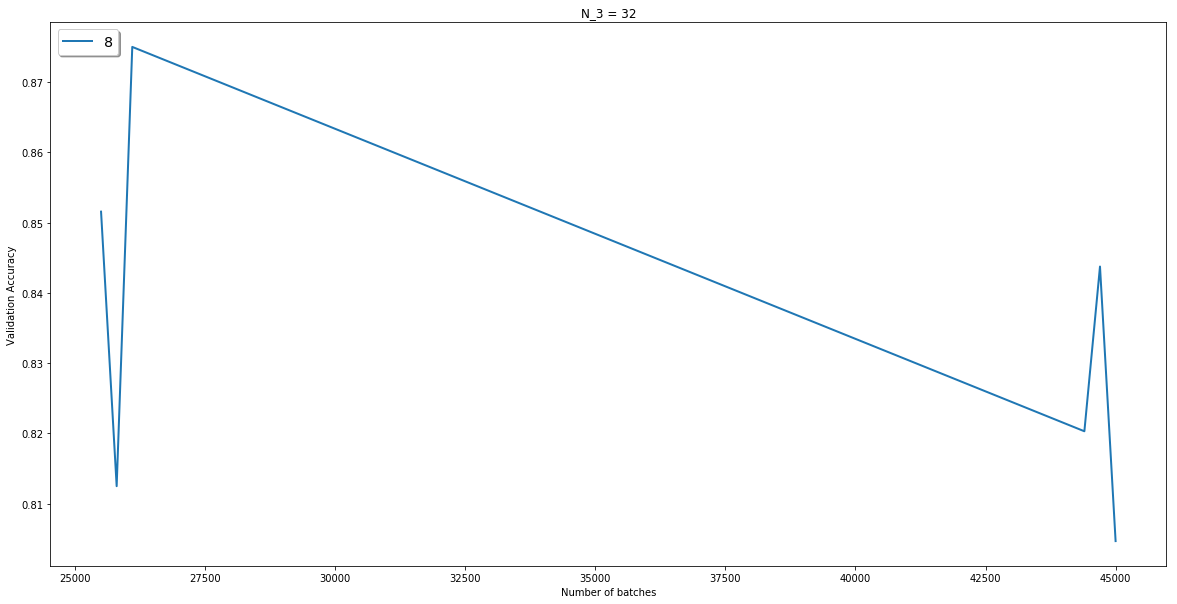

In [11]:
run_id =  8
z_dim = 10
plt.figure(figsize=(20,10))
accuracy_dict =dict()
N_3 = 32
N_2 =  128
#for version in ["","_old"]:
#for z_dim in [10]:
# BASE_PATH_1 = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=1)
# BASE_PATH_2 = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=2)
# BASE_PATH_3 = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=3)


BASE_PATH_4 = "/Users/sunilkumar/concept_learning/image_classification/Exp_10_032_128_1"
BASE_PATH_5 = "/Users/sunilkumar/concept_learning/image_classification/Exp_10_032_128_6"
# BASE_PATH_6 = "/Users/sunilkumar/concept_learning/image_classification_old/Exp_10_032_128/"
# BASE_PATH_7 = "/Users/sunilkumar/concept_learning/image_classification_old/Exp_10_032_128_old/"
#BASE_PATH = "/Users/sunilkumar/concept_learning/image_classification/Exp_10_032_128_1"

#for BASE_PATH in [BASE_PATH_4,BASE_PATH_5]:
#for run_id in [1,2,3]:
#for BASE_PATH in [BASE_PATH_1,BASE_PATH_2,BASE_PATH_3,BASE_PATH_4,BASE_PATH_5,BASE_PATH_6]:
for run_id in [8]:
    BASE_PATH = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=run_id)
    DATASET_ROOT_PATH = os.path.join(BASE_PATH,DATASET_NAME+"/")
    DATASET_PATH = os.path.join(DATASET_ROOT_PATH, SPLIT_NAME+"/")
    MODEL_NAME_WITH_CONFIG = "{}_{}_{:2d}_{:02d}".format(MODEL_NAME, DATASET_NAME, BATCH_SIZE, z_dim)

    
    MODEL_PATH = os.path.join(DATASET_PATH, MODEL_NAME_WITH_CONFIG)
    SPLIT_PATH = os.path.join(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS, SPLIT_NAME + "/")
    TRAINED_MODELS_PATH = os.path.join(MODEL_PATH, "trained_models/")
    PREDICTION_RESULTS_PATH = os.path.join(MODEL_PATH, "prediction_results/")

    if annotator == "SUNIL":
        ANNOTATED_PATH = DATASET_PATH + "manual_annotation_sunil"
    elif annotator == "VIJAY":
        BASE_PATH = "/home/test/"
        ANNOTATED_PATH = DATASET_PATH + "manual_annotation_vijay"
    else:
        raise Exception("Only two annotators {} and {} are allowed now".format("SUNIL", "VIJAY"))
        
        
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file)

    df,unique = get_annotations(ANNOTATED_PATH)
    unique = unique[unique["count"] > 10]
    
    epochs = []
    steps = []
    accuracies = []
    total_batches_finished = []
    for unique_combination in unique.iterrows():
        epoch = unique_combination[1]["epoch"]
        step = unique_combination[1]["step"]
        accuracy = compute_accruacy(df,step,epoch,num_images)
        accuracies.append(accuracy)
        total_batches_finished.append(epoch * 900 + step * eval_interval )

    accuracy_df = pd.DataFrame({"Total_Batches_Finished":total_batches_finished,"Accuracy":accuracies})

    x = accuracy_df["Total_Batches_Finished"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])
    legend = "run_id={}".format(run_id)

    plt.plot(x,y,label=run_id,lw=2)
    plt.xlabel("Number of batches")
    plt.ylabel("Validation Accuracy")
    accuracy_dict[z_dim] = max(accuracies)
#legends = ["z_dim={}".format(dim) for  dim in z_dims]
#print(legends)
#plt.legend([legends])
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_filename = ROOT_PATH +"combined_analysis/" + "accuracy.png"
plt.title("N_3 = {}".format(N_3))
print(plot_filename)
plt.savefig(plot_filename,bbox="tight")


In [10]:
accuracy_dict

{10: 0.875}

In [12]:
accuracy_df.head()

,Total_Batches_Finished,Accuracy
0,25500,0.851562
1,25800,0.812500
2,26100,0.875000
3,44400,0.820312
4,44700,0.843750


In [7]:
z_dim = 10

plt.figure(figsize=(20, 10))
accuracy_dict =dict()
N_3 = 32
N_2 = 128
#for N_3 in [16,32]:
for N_2 in [64,128]:
    BASE_PATH = get_base_path(z_dim, N_3, N_2)
    DATASET_ROOT_PATH = os.path.join(BASE_PATH, DATASET_NAME + "/")
    DATASET_PATH = os.path.join(DATASET_ROOT_PATH, SPLIT_NAME + "/")
    MODEL_NAME_WITH_CONFIG = "{}_{}_{:2d}_{:02d}".format(MODEL_NAME, DATASET_NAME, BATCH_SIZE, z_dim)

    MODEL_PATH = os.path.join(DATASET_PATH, MODEL_NAME_WITH_CONFIG)
    SPLIT_PATH = os.path.join(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS, SPLIT_NAME + "/")
    TRAINED_MODELS_PATH = os.path.join(MODEL_PATH, "trained_models/")
    PREDICTION_RESULTS_PATH = os.path.join(MODEL_PATH, "prediction_results/")

    if annotator == "SUNIL":
        ANNOTATED_PATH = DATASET_PATH + "manual_annotation_sunil"
    elif annotator == "VIJAY":
        BASE_PATH = "/home/test/"
        ANNOTATED_PATH = DATASET_PATH + "manual_annotation_vijay"
    else:
        raise Exception("Only two annotators {} and {} are allowed now".format("SUNIL", "VIJAY"))
        
        
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file)
    
    df,unique = get_annotations(ANNOTATED_PATH)
    unique = unique[unique["count"] > 10]
    
    epochs = []
    steps = []
    accuracies = []
    total_batches_finished = []
    for unique_combination in unique.iterrows():
        epoch = unique_combination[1]["epoch"]
        step = unique_combination[1]["step"]
        accuracy = compute_accruacy(df,step,epoch,num_images)
        accuracies.append(accuracy)
        total_batches_finished.append(epoch * 900 + step * eval_interval )

    accuracy_df = pd.DataFrame({"Total_Batches_Finished":total_batches_finished,"Accuracy":accuracies})

    x = accuracy_df["Total_Batches_Finished"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])
    legend = "n_3={}".format(N_3)

    plt.plot(x,y,label=legend,lw=2)
    plt.xlabel("Number of batches")
    plt.ylabel("Validation Accuracy")
    accuracy_dict[z_dim] = max(accuracies)
#legends = ["z_dim={}".format(dim) for  dim in z_dims]
#print(legends)
#plt.legend([legends])
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_filename = ROOT_PATH +"combined_analysis/" + "accuracy.png"
plt.title("z_dim = {}".format(z_dim))
print(plot_filename)
plt.savefig(plot_filename,bbox="tight")


FileNotFoundError: File b'/Users/sunilkumar/concept_learning/image_classification/Exp_10_032_064/mnist/Split_1/VAE_mnist_64_10/prediction_results//label_test_00.csv' does not exist

<Figure size 1440x720 with 0 Axes>

In [8]:
accuracy_dict

{5: 0.578125, 10: 0.6171875}